# Use of python in order to push the csv file into mysql

In [8]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('order_items.csv','order_items'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments')  # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='V@ibhav100204',
    database='target'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/91823/Documents/Exploratory Data Analysis/Target'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing order_items.csv
NaN values before replacement:
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state            

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "V@ibhav100204",
                            database = "target")          # this is for the connection 

cur = db.cursor()           # this is for the activation of the cursor

# List all unique cities where customers are located.

In [28]:
query = """ select distinct (customer_city) from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [50]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

('The total no. of orders placed in year 2017 are ' ,data[0][0])

('The total no. of orders placed in year 2017 are ', 180404)

# Find the total sales per category.

In [19]:
query = """ select upper(products.product_category) category, 
round(sum(payments.payment_value),2) sales
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data , columns=["Category","Sales"])
df

,Category,Sales
0,PERFUMERY,24323455.67
1,FURNITURE DECORATION,68648466.81
2,TELEPHONY,23370338.43
3,BED TABLE BATH,82202576.21
4,AUTOMOTIVE,40910127.89
...,...,...
69,CDS MUSIC DVDS,57572.64
70,LA CUISINE,139849.44
71,FASHION CHILDREN'S CLOTHING,37712.16
72,PC GAMER,104372.64


# Calculate the percentage of orders that were paid in installments.

In [20]:
query =""" select (sum(case 
when payment_installments >= 1 then 1
else 0
end))/count(*)*100
from payments
"""

cur.execute(query)

data = cur.fetchall()

("The percentage of orders that were paid in installments are" ,data[0][0])

('The percentage of orders that were paid in installments are',
 Decimal('99.9981'))

# Count the number of customers from each state. 

<function matplotlib.pyplot.show(close=None, block=None)>

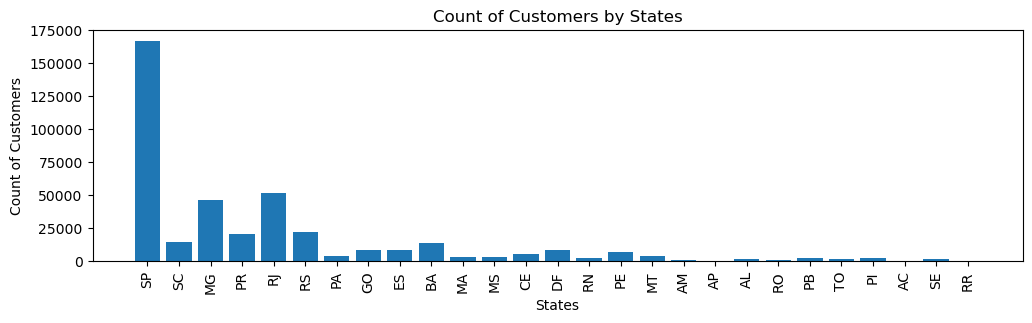

In [27]:
query = """ select customer_state , count(customer_id) from customers group by customer_state """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data , columns = ["State","Customer_Count"])

plt.figure(figsize=(12,3))
plt.bar(df["State"],df["Customer_Count"])
plt.xlabel("States")
plt.ylabel("Count of Customers")
plt.title("Count of Customers by States")
plt.xticks(rotation = 90)
plt.show

# Calculate the number of orders per month in 2018.

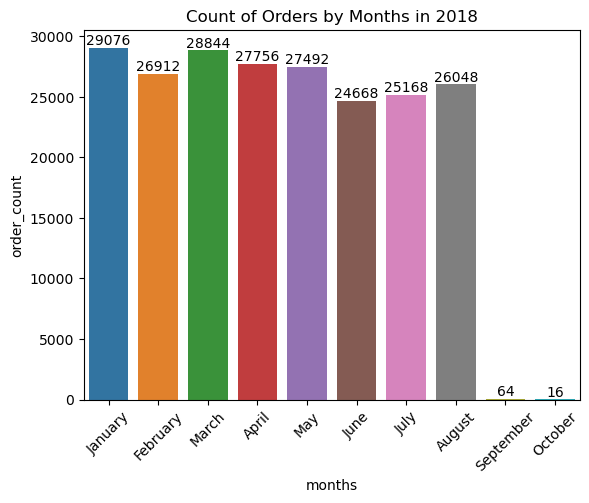

In [42]:
query = """ select monthname(order_purchase_timestamp) months , count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018 
group by months """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data , columns = ["months","order_count"])
o = ["January","February","March","April","May","June","July","August","September","October"]

a = sns.barplot(x = df["months"] , y = df["order_count"] , data = df , order = o)
plt.xticks(rotation = 45)
a.bar_label(a.containers[0])
plt.title("Count of Orders by Months in 2018")
plt.show()


# Find the average number of products per order, grouped by customer city.

In [46]:
query = """ with count_per_order as
(select orders.order_id , orders.customer_id , count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id , orders.customer_id)

select customers.customer_city , round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data , columns = ["Customer City", "Average Product/Order"])
df.head(10)



,Customer City,Average Product/Order
0,padre carvalho,112.00
1,celso ramos,104.00
2,datas,96.00
3,candido godoi,96.00
4,matias olimpio,80.00
5,cidelandia,64.00
6,curralinho,64.00
7,picarra,64.00
8,morro de sao paulo,64.00
9,teixeira soares,64.00


# Calculate the percentage of total revenue contributed by each product category.

In [51]:
query = """ select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data , columns = ["Product Category", "Sales Percentage"])
df.head(10)



,Product Category,Sales Percentage
0,BED TABLE BATH,171.16
1,HEALTH BEAUTY,165.65
2,COMPUTER ACCESSORIES,158.45
3,FURNITURE DECORATION,142.94
4,WATCHES PRESENT,142.84
5,SPORT LEISURE,139.14
6,HOUSEWARES,109.42
7,AUTOMOTIVE,85.18
8,GARDEN TOOLS,83.78
9,COOL STUFF,77.93


# Identify the correlation between product price and the number of times a product has been purchased.

In [57]:
query = """ select products.product_category, count(order_items.order_id),
round(avg(order_items.price),2) from products join order_items
on products.product_id = order_items.product_id
group by products.product_category
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data , columns = ["Product Category", "Order Count", "Price"])
df.head(10)

arr1 = df["Order Count"]
arr2 = df["Price"]

a = np.corrcoef([arr1,arr2])
print("the correlation is", a[0][-1])

the correlation is -0.10631514167157563


# Calculate the total revenue generated by each seller, and rank them by revenue.

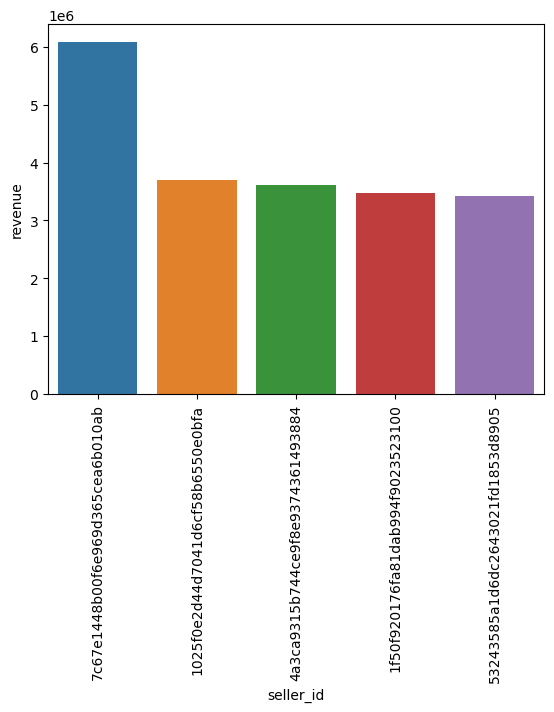

In [69]:
query = """ select * , dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value) revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id","revenue","rank"])
df = df.head()
sns.barplot(x = "seller_id" , y = "revenue" , data = df)
plt.xticks(rotation = 90)
plt.show()


# Calculate the moving average of order values for each customer over their order history.

In [75]:
query = """ select customer_id , order_purchase_timestamp,payment,
avg(payment) over (partition by customer_id order by order_purchase_timestamp 
rows between 2 preceding and current row)
from
(select orders.customer_id , orders.order_purchase_timestamp , 
payments.payment_value as payment
from payments join orders on 
payments.order_id = orders.order_id) as a
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
1246627,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
1246628,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
1246629,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
1246630,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# Calculate the cumulative sales per month for each year.

In [83]:
query = """ select years, months , 
sum(payment) over(order by years,months) as cummulative_sales from
(select year(orders.order_purchase_timestamp) as years ,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment
from orders join payments on
orders.order_id = payments.order_id
group by years ,months order by years,months) as a
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2
0,2016,9,3.026880e+03
1,2016,10,7.121126e+05
2,2016,12,7.123481e+05
3,2017,1,2.374205e+06
4,2017,2,5.877101e+06
5,2017,3,1.127546e+07
6,2017,4,1.628892e+07
7,2017,5,2.340395e+07
8,2017,6,2.953926e+07
9,2017,7,3.664786e+07


# Calculate the year-over-year growth rate of total sales.

In [89]:
query = """ with a as (select year(orders.order_purchase_timestamp) as years ,
round(sum(payments.payment_value),2) as payment
from orders join payments on
orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data , columns =["year","growth",])
df

,year,growth
0,2016,NaN
1,2017,12112.703759
2,2018,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [94]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()

data[0]
# Since none of our customers are repeated so it is showing None values

(None,)

# Identify the top 3 customers who spent the most money in each year.

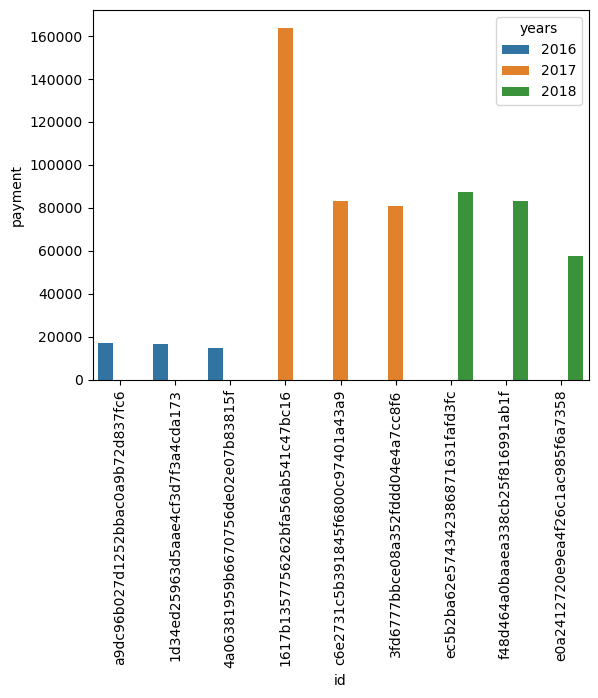

In [101]:
query = """ select years , customer_id , payment , d_rank from
(select year(orders.order_purchase_timestamp) as years ,
orders.customer_id , sum(payments.payment_value) payment,
dense_rank() over (partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value)desc) as d_rank
from orders join payments
on orders.order_id = payments.order_id
group by orders.customer_id,year(orders.order_purchase_timestamp)) as a
where d_rank <= 3
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
df['years'] = df['years'].astype(str)
sns.barplot(x = "id", y = "payment", data = df ,hue= "years")
plt.xticks(rotation = 90)
plt.show()